# Sequential Importance Sampling (SIS)

heres an algorithm from a big book, Probabilistic Machine Learning Advanced Topics:

![image](images/Screenshot%20from%202024-10-17%2013-54-06.png)

Actually implement simons alg for static tracking first as it will be easier:

![images](images/GreenMaskAlg1.png)
![images](images/GreenMaskAlg2.png)

In [ ]:
%% capture output
%pip install numpy
%pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt


some of these functions used to take advantage of some numpy matrix maths / element wise multiplication stuff to make them faster but I dumbed them all down during troubleshooting, so the code is probably a lot slower because of that - although it only takes 100ms to run

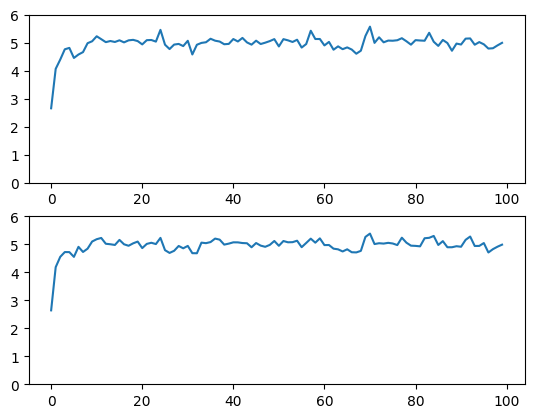

In [153]:
def initial_theta(n):
    return np.random.randn(n)

def normal_dist(x,mu,var):
    sigma = var**(1/2)
    return (1/(sigma*(np.pi*2)**(1/2)))*np.e**(-0.5*((x-mu)/sigma)**2)

def target_dist_p(x):
    return normal_dist(x,5,var=0.5)

def new_proposal(old_thetas):
    return np.array(old_thetas+np.random.randn(len(old_thetas)))

def initial_weights(theta):
    weights = []
    for t in theta:
        weights.append(target_dist_p(t)/normal_dist(t,0,1))
    return np.array(weights)

def resample(curr_theta, weights):
    new_theta = []
    new_theta = np.random.choice(curr_theta,size = len(curr_theta), p=weights)
    return np.array(new_theta)

def norm_weights(w_un):
    w_sum = sum(w_un)
    weights = []
    for w in w_un:
        weights += [w/w_sum]
    return np.array(weights)

def get_neff(weights):
    squared_sum = 0
    for w in weights:
        squared_sum += w*w
    return 1/squared_sum

def new_unnormed_weights(old_weights, curr_theta, old_theta):
    weights = []
    for w, t0, t1 in zip(old_weights, curr_theta, old_theta):
        weights.append(w*(target_dist_p(t0)/target_dist_p(t1)))
    return np.array(weights)

theta, weights_unnormed, weights_normed, n, k = [], [], [], 100, 0

theta = [initial_theta(n)]
weights_unnormed = [initial_weights(theta[-1])]

for i in range(100):
    weights_normed.append(norm_weights(weights_unnormed[-1]))
    Neff = get_neff(weights_normed[-1])
    if Neff<n/2:
        verbose = False
        if verbose:
            w = np.array([f'{w:.6f}' for w in weights_normed[-1]])
            print(f'old sample:\t{theta[-1]}\ntheir weights:\t{w}')
        theta[-1] = resample(theta[-1], weights_normed[-1])
        if verbose:
            print(f'resample:\t{theta[-1]}')
        weights_unnormed[-1] = [1]*len(weights_normed[-1])
        if verbose:
            print(f'new reset weights:\t{weights_unnormed[-1]}')
    k += 1
    theta.append(new_proposal(theta[-1]))
    weights_unnormed.append(new_unnormed_weights(weights_unnormed[-1], theta[-1], theta[-2]))


estimates_weighted_avg = []
estimates_unweighted_mean = []
for w,t in zip(weights_normed,theta):
    estimates_unweighted_mean.append(sum(t)/n)
    estimates_weighted_avg.append(sum(np.multiply(w,t)))

fig,ax = plt.subplots(2)
ax[0].plot(estimates_weighted_avg)
ax[1].plot(estimates_unweighted_mean)
ax[0].set_ylim(0,6)
ax[1].set_ylim(0,6)
plt.show()

# Notes / Questoins

* not sure if the estimation should be the weighted average which to me makes a lot more sense, as unweighted we are just getting the average of the proposal dist? idk
* anyway graph is the same as the one that the alg came from (PLGreen Mask ~2017)
* technically you don't need to store all the weights as each i thread is a markov chain so only depends on the last state's theta, and weights (normed and unnormed), although its worth saying that you can consider resampling as cutting off the head / end of the chain
* tbf surely if a chain is resampled surely we are no longer concerned about the previous values at all as the chain is almost broken a lot of threads new theta values are taken from other threads s ofrom their previous chain, i guess setting all unnormed weights to one reflects this though

* Alessandro said the graph should be weighted average which makes the most sense tbf